In [1]:
from IFD_tsne import *
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
from utils import MidpointNormalize, load_data
import seaborn as sns
import matplotlib.pyplot as plt
from tueplots.constants.color import palettes
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [palettes.tue_plot[0], "white", palettes.tue_plot[3]])


In [2]:
def regularized_KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener):
    """
    (R^nxp x R^nxp)--> R
    """
    X = X_unflattener(X_flat)
    Y = Y_unflattener(Y_flat)
    learning_rate, perplexity = (200, 30.0)
    P = x2p(X, tol=1e-5, perplexity=perplexity)
    P = (P + np.transpose(P))
    P = P / np.sum(P)      # Why don't we devide by 2N as described everywhere?
    P = np.maximum(P, 1e-12)
    Q, _ = y2q(Y)
    return np.sum(P * (np.log(P+1e-10) - np.log(Q+1e-10))) + 1/Y.shape[0] * 0.1*np.sum(np.square(Y))

In [3]:
#X, y = make_blobs(n_samples=50, n_features=50, centers=4, random_state=0, shuffle=False, cluster_std=[0.1, 3, 3, 3])
X, y = load_data(50)
#X, y = make_blobs(n_samples=50, n_features=10, centers=1, random_state=0, shuffle=False)
key = random.PRNGKey(42)

#X = onp.array(random.normal(key, shape=(50, 50)))
y_guess = random.normal(key, shape=(X.shape[0], 2))
#Y_star = TSNE(n_components=2, learning_rate=200, init=onp.array(y_guess), perplexity=30).fit_transform(X)
Y_star = tsne_fwd(X, y_guess)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


===> Finding 49 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 0.9396, 50 iterations in 0.7743 sec
Iteration  100, KL divergence 0.8813, 50 iterations in 0.6702 sec
Iteration  150, KL divergence 0.9791, 50 iterations in 0.6675 sec
Iteration  200, KL divergence 0.9260, 50 iterations in 0.6643 sec
Iteration  250, KL divergence 0.9555, 50 iterations in 0.6596 sec
   --> Time elapsed: 3.44 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 750 iterations...
Iteration   50, KL divergence 0.2590, 50 iterations in 0.6632 sec
Iteration  100, KL divergence 0.1720, 50 iterations in 0.6674 sec
Iteration  150, KL divergence 0.1674, 50 iterations in 0.6693 sec
Iteration  200, KL divergence 0.1674, 50 iterations in 0.6688 sec
Iteration 

In [4]:
X_flat, X_unflattener = flatten_util.ravel_pytree(X)   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star) 

# Regularized

In [5]:
f = lambda x: regularized_KL_divergence(X_flat, x, X_unflattener, Y_unflattener)

In [6]:
dy, H, J = d_y_star_d_x_outer(regularized_KL_divergence, X, Y_star)

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

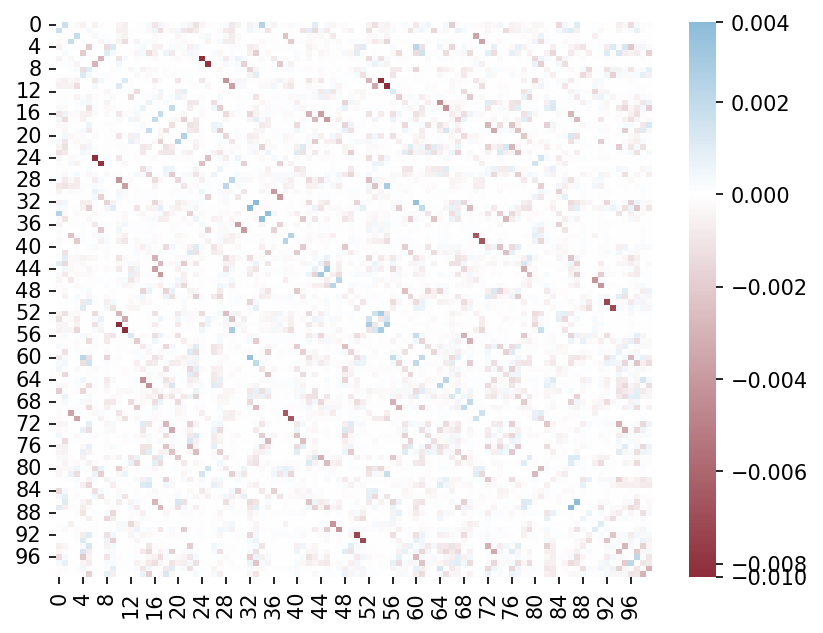

In [7]:
f = plt.figure()
#sns.heatmap(H, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H), vmax=np.max(H))))
sns.heatmap(H-np.diag(np.diag(H)), cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H-np.diag(np.diag(H))), vmax=np.max(H-np.diag(np.diag(H))))))

In [48]:
v, w = np.linalg.eigh(H)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])

In [49]:
print(v)

[0.00400999 0.00401    0.00401001 0.00554101 0.00566863 0.00637503
 0.0068494  0.00726156 0.00832781 0.00880468 0.00902803 0.0094864
 0.01009769 0.01057955 0.01091375 0.01143441 0.01200015 0.01217993
 0.01265533 0.01266687 0.01273345 0.01286955 0.01296745 0.01327426
 0.01352413 0.01366152 0.01379701 0.01390107 0.01425823 0.01439335
 0.0144503  0.01451441 0.01465573 0.01494771 0.01503708 0.01516424
 0.01522509 0.01534647 0.01543534 0.01547283 0.01549435 0.0155345
 0.01569049 0.01584442 0.01605068 0.01616459 0.01620997 0.01634019
 0.01644298 0.01654391 0.0168365  0.01699828 0.01704752 0.01712858
 0.01736532 0.01741061 0.01753211 0.01776459 0.01790643 0.01825311
 0.0183488  0.01845747 0.01866606 0.01880813 0.01884033 0.01905728
 0.01923586 0.01967933 0.01985954 0.02002173 0.02029452 0.02064997
 0.02091361 0.02105625 0.02112854 0.02154093 0.02157635 0.02184286
 0.02207721 0.02221849 0.02280527 0.02319217 0.02321927 0.0235889
 0.02384947 0.02395091 0.02461828 0.02492566 0.02517577 0.0256124

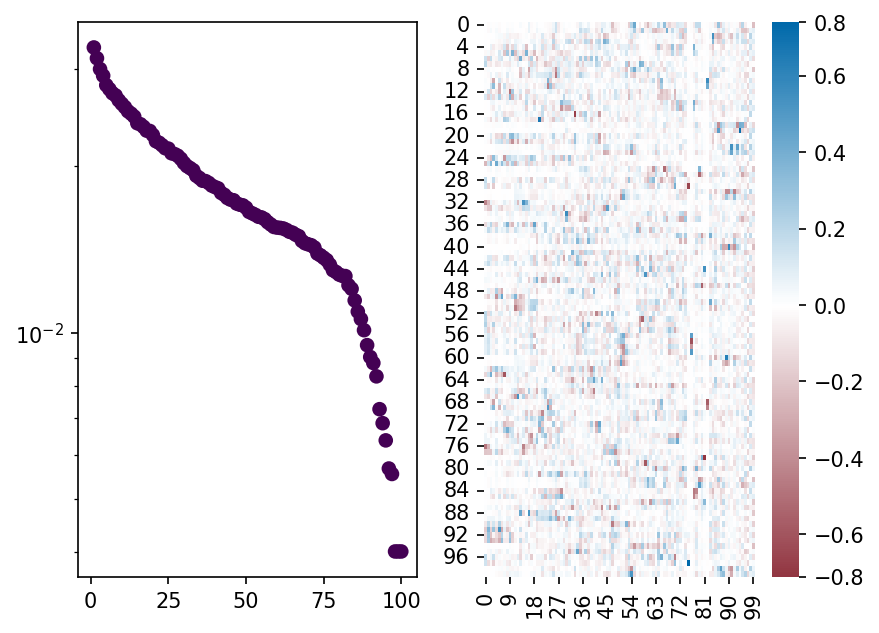

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter([i for i in range(1, len(v)+1)], np.flip(np.sort(np.abs(v))), c=[1 if i>0 else 0 for i in np.flip(np.sort(v))])
sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax2)
ax1.set_yscale('log')

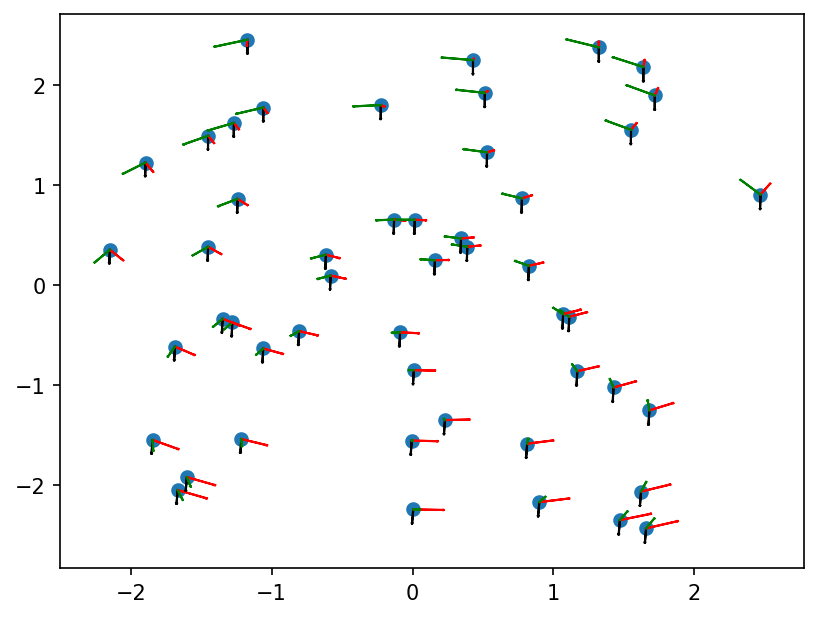

In [51]:
eigenvector = Y_unflattener(w_sorted[:, 97])
#print(eigenvector)
f = plt.figure()
plt.scatter(Y_star[:, 0], Y_star[:, 1])
for i, j in enumerate(Y_star):
    eigenvector = Y_unflattener(w_sorted[:, 97])
    plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1])
    eigenvector = Y_unflattener(w_sorted[:, 98])
    plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color='red')
    eigenvector = Y_unflattener(w_sorted[:, 99])
    plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color='green')

# not regularized

In [59]:
f = lambda x: KL_divergence(X_flat, x, X_unflattener, Y_unflattener)
print(jax.value_and_grad(f)(Y_star))

Computing pairwise distances...
Starting binary search
Entered binary search function
(Array(0.19189283, dtype=float32), Array([[ 3.92115908e-07,  8.69127689e-07],
       [-1.66648533e-07, -4.79340088e-08],
       [ 1.59139745e-07, -1.24389771e-07],
       [ 2.99420208e-07, -2.99885869e-07],
       [ 5.86733222e-08, -1.60653144e-08],
       [-2.94850906e-07,  1.12690032e-07],
       [-5.02914190e-08,  2.65426934e-07],
       [-3.55765224e-07,  6.81029633e-08],
       [-2.96509825e-07,  3.48198228e-07],
       [-2.61701643e-07,  2.60304660e-07],
       [-2.47731805e-07,  2.32830644e-07],
       [ 1.31534762e-07,  7.12985639e-07],
       [-3.46568413e-07,  1.35973096e-07],
       [-7.75326043e-08, -6.62694219e-08],
       [ 6.28991984e-07, -1.63854565e-07],
       [-1.03143975e-07, -5.05242497e-08],
       [-9.82981874e-08, -2.03010131e-07],
       [-7.54516805e-08,  6.23404048e-08],
       [ 1.23691279e-07, -1.12922862e-07],
       [-9.54605639e-09, -5.12227416e-09],
       [-4.35975380

In [60]:
dy2, H2, J2 = d_y_star_d_x_outer(KL_divergence, X, Y_star)
H2 = H2 + 1e-5*np.eye(len(H))

Computing pairwise distances...
Starting binary search
Entered binary search function
Computing pairwise distances...
Starting binary search
Entered binary search function


<AxesSubplot: >

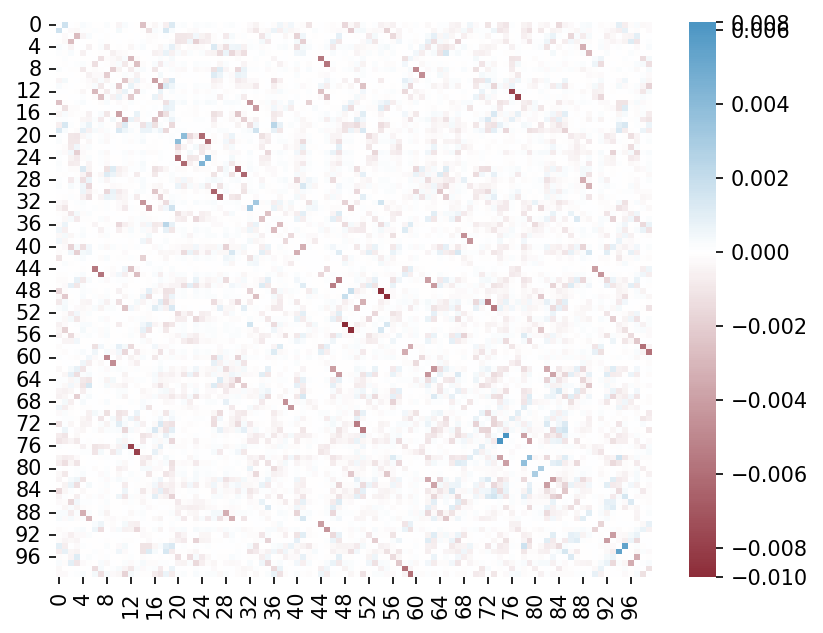

In [61]:
f = plt.figure()
#sns.heatmap(H2, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H2), vmax=np.max(H2))))
sns.heatmap(H2-np.diag(np.diag(H2)), cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H2-np.diag(np.diag(H2))), vmax=np.max(H2-np.diag(np.diag(H2))))))

In [62]:
v, w = np.linalg.eigh(H2)
w_sorted = np.transpose(np.transpose(w)[np.flip(np.argsort(v))])
print(v)

[1.99963142e-05 1.99983915e-05 2.00068134e-05 3.20762862e-04
 1.02704263e-03 1.22026436e-03 1.50696374e-03 1.96250994e-03
 3.07079195e-03 3.29944561e-03 3.80634679e-03 3.92939616e-03
 4.18646540e-03 4.90497332e-03 5.09925792e-03 5.75073389e-03
 6.03409531e-03 6.29466912e-03 6.51820377e-03 6.88314205e-03
 7.52066635e-03 7.67803797e-03 7.89926387e-03 8.29416793e-03
 8.76613054e-03 8.89813341e-03 9.25486814e-03 9.66657978e-03
 1.01218596e-02 1.04295919e-02 1.08117526e-02 1.09053571e-02
 1.12388311e-02 1.13531165e-02 1.16298124e-02 1.18672978e-02
 1.21773053e-02 1.23514924e-02 1.24394242e-02 1.26207201e-02
 1.27758486e-02 1.33200604e-02 1.36394165e-02 1.36471391e-02
 1.37809757e-02 1.39337555e-02 1.40450504e-02 1.42637966e-02
 1.45337069e-02 1.46993687e-02 1.52900042e-02 1.55928433e-02
 1.57335550e-02 1.59010161e-02 1.63049083e-02 1.64604709e-02
 1.65975709e-02 1.70795675e-02 1.71565376e-02 1.73898749e-02
 1.76662486e-02 1.78789012e-02 1.81976799e-02 1.85947288e-02
 1.88094825e-02 1.905443

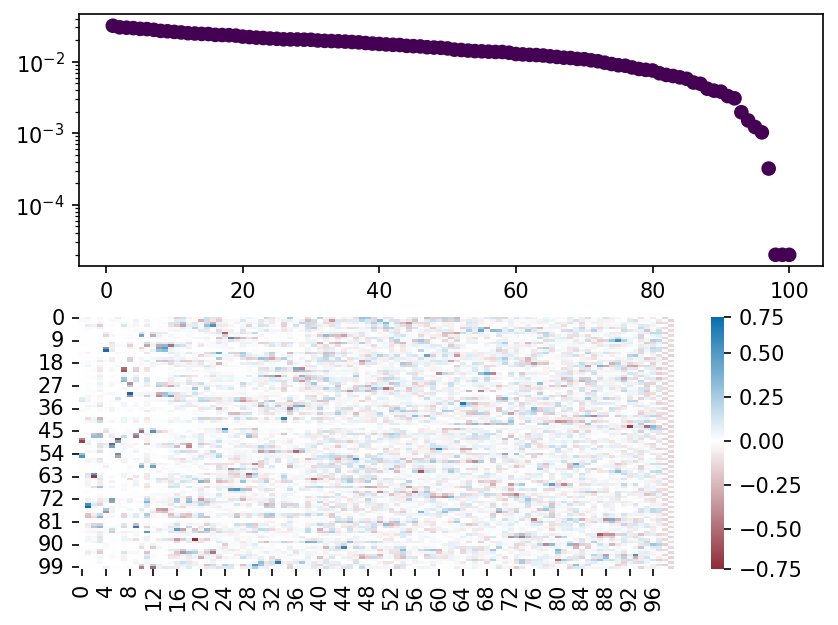

In [63]:
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.scatter([i for i in range(1, len(v)+1)], np.flip(np.sort(np.abs(v))), c=[1 if i>0 else 0 for i in np.flip(np.sort(v))])
sns.heatmap(w_sorted, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(w_sorted), vmax=np.max(w_sorted))), ax=ax2)
ax1.set_yscale('log')

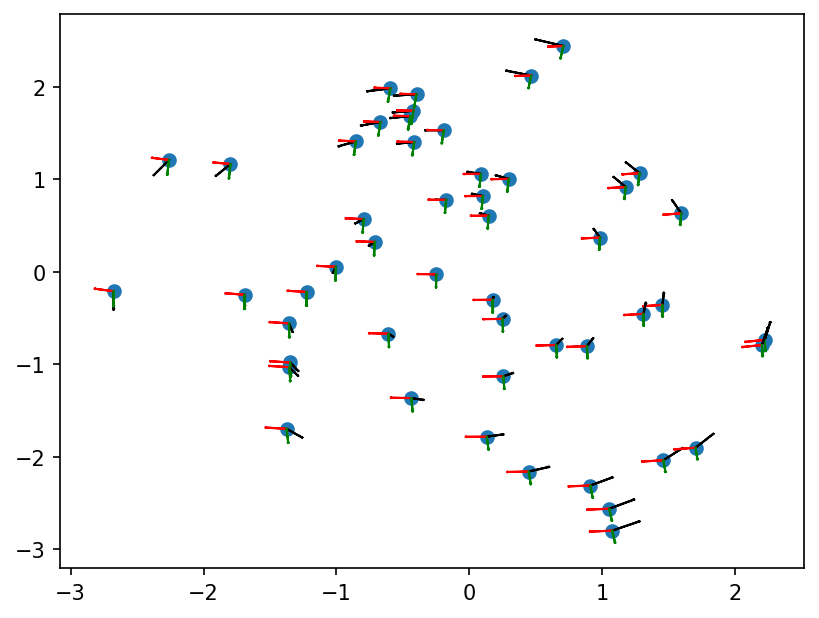

In [64]:
eigenvector = Y_unflattener(w_sorted[:, 97])
#print(eigenvector)
f = plt.figure()
plt.scatter(Y_star[:, 0], Y_star[:, 1])
for i, j in enumerate(Y_star):
    eigenvector = Y_unflattener(w_sorted[:, 97])
    plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1])
    eigenvector = Y_unflattener(w_sorted[:, 98])
    plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color='red')
    eigenvector = Y_unflattener(w_sorted[:, 99])
    plt.arrow(j[0], j[1], eigenvector[i, 0], eigenvector[i, 1], color='green')
    

In [23]:
print('Condition number regularized (higher numbers are bad): ', np.linalg.cond(H))

Condition number regularized (higher numbers are bad):  9.105356


In [24]:
print('Condition number NOT regularized (higher numbers are bad): ', np.linalg.cond(H2))

Condition number NOT regularized (higher numbers are bad):  3251.8818


In [34]:
print('Condition number NOT regularized (higher numbers are bad): ', np.linalg.cond(H2+1e-2*np.eye(len(H2))))

Condition number NOT regularized (higher numbers are bad):  4.3045483


In [26]:
regularized_KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array(0.4355191, dtype=float32)

In [27]:
KL_divergence(X_flat, Y_flat, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array(0.22678576, dtype=float32)

In [28]:
regularized_KL_divergence(X_flat, Y_flat+1, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array(0.63551897, dtype=float32)

In [29]:
KL_divergence(X_flat, Y_flat+5, X_unflattener, Y_unflattener)

Computing pairwise distances...
Starting binary search
Entered binary search function


Array(0.22678548, dtype=float32)

<AxesSubplot: >

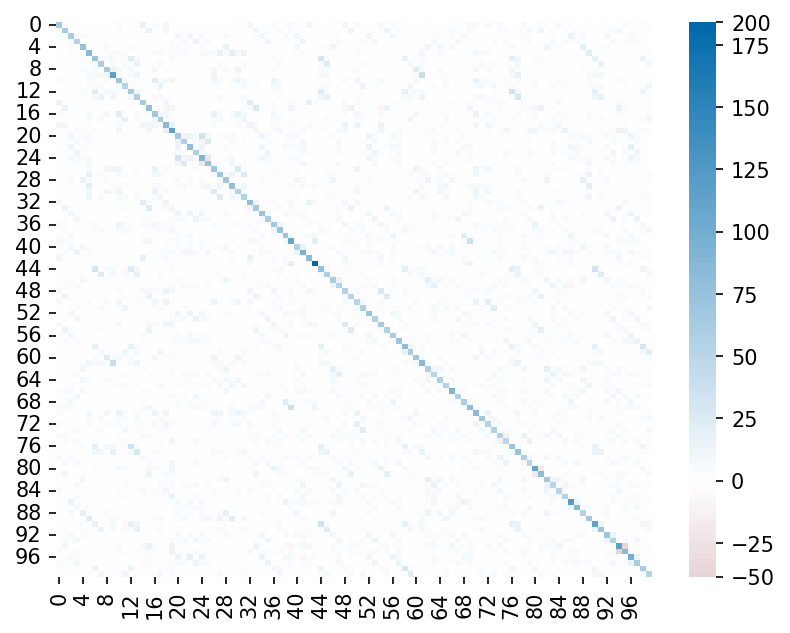

In [66]:
L, lower = jax.scipy.linalg.cho_factor(H, lower=True)
u = jax.scipy.linalg.solve_triangular(L, np.eye(np.shape(L)[0]), lower=True)
L_t, lower = jax.scipy.linalg.cho_factor(H, lower=False)
H_inv = jax.scipy.linalg.solve_triangular(L_t, u, lower=False)
f = plt.figure()
sns.heatmap(H_inv, cmap=cmap, norm=(MidpointNormalize(midpoint=0, vmin=np.min(H_inv), vmax=np.max(H_inv))))